In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
import seaborn as sns

In [24]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise',6:'disgust'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5,'disgust':6}

dic = {'images':[], 'labels':[], 'purpose':[]}

for d in os.listdir('./fer2013/'):
    print(d)
    for emotion in os.listdir(f'./fer2013/{d}'):
        print(emotion)
        for i in os.listdir(f'./fer2013/{d}/{emotion}'):
            img = cv2.imread(f'./fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)

            dic['images'].append(img)
            dic['labels'].append(emotion)

            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')

df = pd.DataFrame(dic)
df.head()

test
angry
disgust
fear
happy
neutral
sad
surprise
train
angry
disgust
fear
happy
neutral
sad
surprise


,images,labels,purpose
0,"[[[46], [34], [26], [23], [12], [32], [35], [2...",angry,V
1,"[[[55], [33], [54], [32], [26], [21], [50], [2...",angry,V
2,"[[[123], [123], [126], [131], [124], [69], [10...",angry,V
3,"[[[255], [255], [255], [255], [255], [255], [2...",angry,V
4,"[[[127], [121], [124], [137], [123], [118], [1...",angry,V


In [47]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [48]:
train_data.head()

,images,labels,purpose
7178,"[[[50], [32], [15], [11], [12], [10], [10], [8...",angry,T
7179,"[[[29], [24], [29], [11], [15], [22], [26], [1...",angry,T
7180,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",angry,T
7181,"[[[155], [138], [98], [112], [94], [97], [111]...",angry,T
7182,"[[[211], [215], [220], [221], [219], [216], [2...",angry,T


In [49]:
val_data.head()

,images,labels,purpose
0,"[[[46], [34], [26], [23], [12], [32], [35], [2...",angry,V
1,"[[[55], [33], [54], [32], [26], [21], [50], [2...",angry,V
2,"[[[123], [123], [126], [131], [124], [69], [10...",angry,V
3,"[[[255], [255], [255], [255], [255], [255], [2...",angry,V
4,"[[[127], [121], [124], [137], [123], [118], [1...",angry,V


In [50]:
train_data['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

In [51]:
val_data['labels'].value_counts()

labels
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64

In [52]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=3171)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3171)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3171)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3171)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3171)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3171)
disgust_df = train_data[train_data['labels']=='disgust'].sample(n=436)

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df, disgust_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose
0,"[[[3], [5], [17], [28], [19], [24], [47], [55]...",angry,T
1,"[[[6], [10], [11], [6], [5], [41], [81], [66],...",happy,T
2,"[[[212], [193], [188], [191], [195], [201], [1...",angry,T
3,"[[[83], [84], [87], [85], [97], [92], [101], [...",sad,T
4,"[[[63], [63], [69], [59], [59], [46], [31], [5...",angry,T


In [53]:
train_data['labels'].value_counts()

labels
angry       3171
happy       3171
sad         3171
surprise    3171
fear        3171
neutral     3171
disgust      436
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

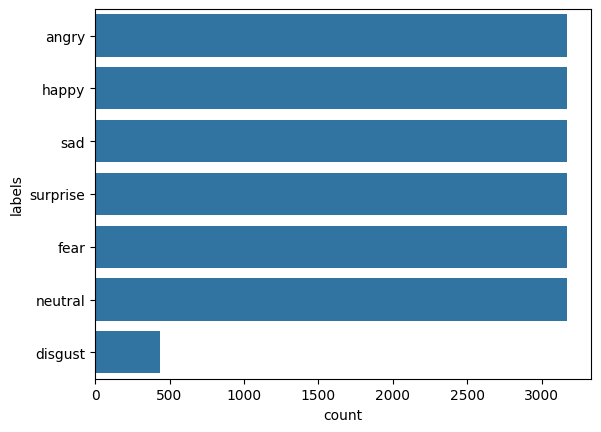

In [54]:
sns.countplot(train_data['labels'])

In [55]:
batch_size= 32
classes = 7
rows,columns=48,48

In [56]:
val_data['labels'].value_counts()

labels
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64

In [57]:
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [58]:
train_data.shape

(19462, 48, 48, 1)

In [59]:
val_data.shape

(7178, 48, 48, 1)

In [60]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_22 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_23 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

In [61]:
checkpoint = ModelCheckpoint('model\\6_class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

In [62]:
train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/30
441/441 [==============================] - ETA: 0s - loss: 2.3128 - accuracy: 0.1876
Epoch 1: val_loss improved from inf to 1.84272, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 36s 71ms/step - loss: 2.3128 - accuracy: 0.1876 - val_loss: 1.8427 - val_accuracy: 0.2336
Epoch 2/30
441/441 [==============================] - ETA: 0s - loss: 1.7501 - accuracy: 0.2896
Epoch 2: val_loss improved from 1.84272 to 1.50716, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 28s 63ms/step - loss: 1.7501 - accuracy: 0.2896 - val_loss: 1.5072 - val_accuracy: 0.4266
Epoch 3/30
441/441 [==============================] - ETA: 0s - loss: 1.4934 - accuracy: 0.4214
Epoch 3: val_loss improved from 1.50716 to 1.47040, saving model to model\6_class_emotion_detector_V2.h5
441/441 [==============================] - 28s 63ms/step - loss: 1.4934 - accuracy: 0.4214 - val_loss: 1.4704 - val_accuracy: 0.4448
Ep

In [1]:
import cv2
from keras.models import load_model
import numpy as np

int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise',6:'disgust'}
model = load_model('model\\6_class_emotion_detector_V2.h5')
cap = cv2.VideoCapture(0)

classifier = cv2.CascadeClassifier('Haarcascades\\haarcascade_frontalface_default.xml')

def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if len(faces) == 0:
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))],
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame

while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('emotion_detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step


KeyboardInterrupt: 

: 